<a href="https://colab.research.google.com/github/thom126f/stroke/blob/main/BP_dataset_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!#pip install shap
!#pip install eli5
!#pip install pywaffle
!#pip install umap-learn

import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time

#visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

from pywaffle import Waffle

%matplotlib inline
init_notebook_mode(connected=True)

#Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             precision_score,
                             recall_score,
                             f1_score, 
                             roc_auc_score,
                             confusion_matrix,
                             make_scorer)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.metrics import classification_report

# dimensionality reduction
from sklearn.decomposition import PCA

from umap import UMAP
import pylab as pl

# imbalance dataset handling
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)
from imblearn.over_sampling import (SMOTE,
                                    ADASYN)


# model algorithams
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Success metrics for the models
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler # to scale the numeric features

#SMOTE technique to deal with unbalanced data problem
from imblearn.over_sampling import SMOTE

#splitting the dataset into test-train
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Algorithms for using supervised learning methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor


#Feature Importance-Explainable AI Libraries

import shap
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance



In [ ]:
df = pd.read_csv('/content/Stroke Prediction Dataset.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Missing data:

In [ ]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Dealing with missing variables using decision tree. From https://www.kaggle.com/code/thomaskonstantin/analyzing-and-modeling-stroke-data/notebook

In [ ]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [ ]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


Distribution of variables.

Visualization of variable distribution, from https://www.kaggle.com/code/bhuvanchennoju/data-storytelling-auc-focus-on-strokes

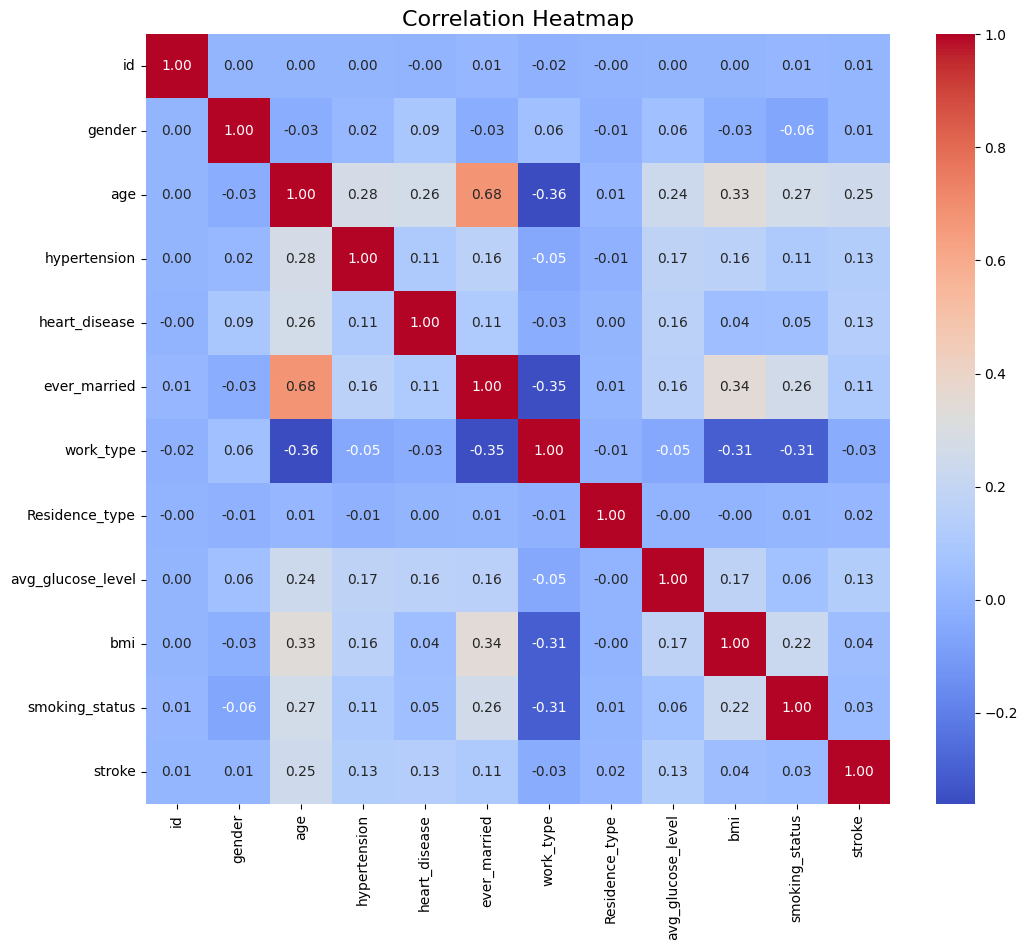

In [ ]:
# temporarily convert non-numeric variables to numeric variables
df['gender'] = pd.Categorical(df['gender']).codes
df['ever_married'] = pd.Categorical(df['ever_married']).codes
df['work_type'] = pd.Categorical(df['work_type']).codes
df['Residence_type'] = pd.Categorical(df['Residence_type']).codes
df['smoking_status'] = pd.Categorical(df['smoking_status']).codes

# Create a correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure and heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)

# Add title and adjust fontsize
ax.set_title("Correlation Heatmap", fontsize=16)

# Show the plot
plt.show()

Data modification

Remove "id"

In [ ]:
df = df.drop('id', axis=1)

remove "other" gender.

In [ ]:
# calculate the count and percentage of each unique value of the 'gender' variable
gender_counts = df['gender'].value_counts()
gender_percentages = round(df['gender'].value_counts(normalize=True) * 100, 2)

# display the results
print('Gender Counts:')
print(gender_counts)
print('\nGender Percentages:')
print(gender_percentages)

Gender Counts:
0    2994
1    2115
2       1
Name: gender, dtype: int64

Gender Percentages:
0    58.59
1    41.39
2     0.02
Name: gender, dtype: float64


In [ ]:
df = df[df['gender'] != 'Other']

In [ ]:
# loop through the columns in the DataFrame
for col in df.columns:
    # check if the column is of object type
    if df[col].dtype == 'object':
        # print the unique values
        print(col + ': ' + str(df[col].unique()))

In [ ]:
# create dummy variables for the 'gender' variable
gender_dummies = pd.get_dummies(df['gender'], prefix='gender', drop_first=True)

# create dummy variables for the 'ever_married' variable
married_dummies = pd.get_dummies(df['ever_married'], prefix='married', drop_first=True)

# create dummy variables for the 'work_type' variable
work_dummies = pd.get_dummies(df['work_type'], prefix='work', drop_first=True)

# create dummy variables for the 'Residence_type' variable
residence_dummies = pd.get_dummies(df['Residence_type'], prefix='residence', drop_first=True)

# create dummy variables for the 'smoking_status' variable
smoking_dummies = pd.get_dummies(df['smoking_status'], prefix='smoking', drop_first=True)

# concatenate the original DataFrame with the new dummy variable DataFrames
df = pd.concat([df, gender_dummies, married_dummies, work_dummies, residence_dummies, smoking_dummies], axis=1)

# drop the original categorical variables from the DataFrame
df = df.drop(['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis=1)

# display the first few rows of the new DataFrame
print(df.head())

    age  hypertension  heart_disease  avg_glucose_level        bmi  stroke  \
0  67.0             0              1             228.69  36.600000       1   
1  61.0             0              0             202.21  29.879487       1   
2  80.0             0              1             105.92  32.500000       1   
3  49.0             0              0             171.23  34.400000       1   
4  79.0             1              0             174.12  24.000000       1   

   gender_1  gender_2  married_1  work_1  work_2  work_3  work_4  residence_1  \
0         1         0          1       0       1       0       0            1   
1         0         0          1       0       0       1       0            0   
2         1         0          1       0       1       0       0            0   
3         0         0          1       0       1       0       0            1   
4         0         0          1       0       0       1       0            0   

   smoking_1  smoking_2  smoking_3  
0      

Normalizing continues variable. This should be done after splitting the data into training and test sets to avoid data leakage of the distribution of the variables that comes from the test set.

In [ ]:
# split the dataset into features (X) and target variable (y)
X = df.drop("stroke", axis=1)
y = df["stroke"]

# split the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# list of columns to normalize
columns_to_normalize = ['age', 'avg_glucose_level', 'bmi']

# loop over each column to normalize
for column in columns_to_normalize:
    # extract the column from the train set
    column_train = X_train[column].values.reshape(-1, 1)

    # normalize the column using StandardScaler
    scaler = StandardScaler()
    column_train_norm = scaler.fit_transform(column_train)

    # replace the original column in the train set with the normalized column
    X_train[column] = column_train_norm

# loop over each column to normalize
for column in columns_to_normalize:
    # extract the column from the test set
    column_test = X_test[column].values.reshape(-1, 1)

    # normalize the column using StandardScaler
    scaler = StandardScaler()
    column_test_norm = scaler.fit_transform(column_test)

    # replace the original column in the test set with the normalized column
    X_test[column] = column_test_norm



# print distribution, mean, and standard deviation of each normalized variable in the train set
for column in columns_to_normalize:
    column_train_norm = X_train[column]
    print(f"{column} in train set:\nDistribution: {np.histogram(column_train_norm)[0]}\nMean: {np.mean(column_train_norm):.3f}\nStandard deviation: {np.std(column_train_norm):.3f}\n")

# print distribution, mean, and standard deviation of each normalized variable in the test set
for column in columns_to_normalize:
    column_test_norm = X_test[column]
    print(f"{column} in test set:\nDistribution: {np.histogram(column_test_norm)[0]}\nMean: {np.mean(column_test_norm):.3f}\nStandard deviation: {np.std(column_test_norm):.3f}\n")


age in train set:
Distribution: [291 251 307 346 435 411 468 388 280 400]
Mean: 0.000
Standard deviation: 1.000

avg_glucose_level in train set:
Distribution: [ 896 1235  661  228  104   71  147  148   73   14]
Mean: -0.000
Standard deviation: 1.000

bmi in train set:
Distribution: [ 276 1433 1367  394   73   28    3    1    0    2]
Mean: 0.000
Standard deviation: 1.000

age in test set:
Distribution: [143 111 133 138 162 172 218 171 127 158]
Mean: 0.000
Standard deviation: 1.000

avg_glucose_level in test set:
Distribution: [342 547 306  85  51  22  51  71  46  12]
Mean: -0.000
Standard deviation: 1.000

bmi in test set:
Distribution: [ 84 304 488 401 162  63  18   9   3   1]
Mean: 0.000
Standard deviation: 1.000



In [ ]:
print("y_train distribution:")
print(np.unique(y_train, return_counts=True))

print("y_test distribution:")
print(np.unique(y_test, return_counts=True))

y_train distribution:
(array([0, 1]), array([3417,  160]))
y_test distribution:
(array([0, 1]), array([1444,   89]))


Dealing with uneven distribution of stroke observations. Oversampling, undersampling or robust methods. OBS only sample on the training set. Never sample on the test set.

In [ ]:


# create the undersampling objects
rus = RandomUnderSampler()
cc = ClusterCentroids()
ncr = NeighbourhoodCleaningRule()
nm = NearMiss()
enn = EditedNearestNeighbours()

# create the oversampling objects
smote = SMOTE()
adasyn = ADASYN()

# perform undersampling on the training subset
X_rus_train, y_rus_train = rus.fit_resample(X_train, y_train)
X_cc_train, y_cc_train = cc.fit_resample(X_train, y_train)
X_ncr_train, y_ncr_train = ncr.fit_resample(X_train, y_train)
X_nm_train, y_nm_train = nm.fit_resample(X_train, y_train)
X_enn_train, y_enn_train = enn.fit_resample(X_train, y_train)

# perform oversampling on the training subset
X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)
X_adasyn_train, y_adasyn_train = adasyn.fit_resample(X_train, y_train)

In [ ]:
logreg = LogisticRegression()
cv = 5  # number of cross-validation folds

In [ ]:
# X_rus_train, y_rus_train
scores_rus = cross_val_score(logreg, X_rus_train, y_rus_train, cv=cv)

# X_cc_train, y_cc_train
scores_cc = cross_val_score(logreg, X_cc_train, y_cc_train, cv=cv)

# X_tl_train, y_tl_train
scores_raw = cross_val_score(logreg, X_train, y_train, cv=cv)

# X_ncr_train, y_ncr_train
scores_ncr = cross_val_score(logreg, X_ncr_train, y_ncr_train, cv=cv)

# X_nm_train, y_nm_train
scores_nm = cross_val_score(logreg, X_nm_train, y_nm_train, cv=cv)

# X_enn_train, y_enn_train
scores_enn = cross_val_score(logreg, X_enn_train, y_enn_train, cv=cv)

# X_smote_train, y_smote_train
scores_smote = cross_val_score(logreg, X_smote_train, y_smote_train, cv=cv)

# X_adasyn_train, y_adasyn_train
scores_adasyn = cross_val_score(logreg, X_adasyn_train, y_adasyn_train, cv=cv)


In [ ]:
print("Cross-validation scores:")
print("X_rus_train, y_rus_train: ", scores_rus.mean())
print("X_cc_train, y_cc_train: ", scores_cc.mean())
print("X_train, y_train: ", scores_raw.mean())
print("X_ncr_train, y_ncr_train: ", scores_ncr.mean())
print("X_nm_train, y_nm_train: ", scores_nm.mean())
print("X_enn_train, y_enn_train: ", scores_enn.mean())
print("X_smote_train, y_smote_train: ", scores_smote.mean())
print("X_adasyn_train, y_adasyn_train: ", scores_adasyn.mean())


Cross-validation scores:
X_rus_train, y_rus_train:  0.79375
X_cc_train, y_cc_train:  0.9
X_train, y_train:  0.9552697581747861
X_ncr_train, y_ncr_train:  0.9504234681574584
X_nm_train, y_nm_train:  0.771875
X_enn_train, y_enn_train:  0.9497510713081997
X_smote_train, y_smote_train:  0.8071408144926263
X_adasyn_train, y_adasyn_train:  0.7995591476855254


In [ ]:
# Define a list of tuples where each tuple contains a feature matrix and a corresponding label vector for a specific training set,
# as well as the name of the undersampling or oversampling method applied to generate the training set
train_sets = [(X_train, y_train, 'Raw'),
              (X_rus_train, y_rus_train, 'Random Under-sampling'),
              (X_cc_train, y_cc_train, 'Cluster Centroids Under-sampling'),
              (X_ncr_train, y_ncr_train, 'Near Miss-1 Under-sampling'),
              (X_nm_train, y_nm_train, 'Near Miss-2 Under-sampling'),
              (X_enn_train, y_enn_train, 'Edited Nearest Neighbors Under-sampling'),
              (X_smote_train, y_smote_train, 'SMOTE Over-sampling'),
              (X_adasyn_train, y_adasyn_train, 'ADASYN Over-sampling')]

In [ ]:
for X_train, y_train, method_name in train_sets:
    print("Training set generated using:", method_name)
    print(y_train.value_counts())

Training set generated using: Raw
0    3417
1     160
Name: stroke, dtype: int64
Training set generated using: Random Under-sampling
0    160
1    160
Name: stroke, dtype: int64
Training set generated using: Cluster Centroids Under-sampling
0    160
1    160
Name: stroke, dtype: int64
Training set generated using: Near Miss-1 Under-sampling
0    3027
1     160
Name: stroke, dtype: int64
Training set generated using: Near Miss-2 Under-sampling
0    160
1    160
Name: stroke, dtype: int64
Training set generated using: Edited Nearest Neighbors Under-sampling
0    3064
1     160
Name: stroke, dtype: int64
Training set generated using: SMOTE Over-sampling
0    3417
1    3417
Name: stroke, dtype: int64
Training set generated using: ADASYN Over-sampling
0    3417
1    3388
Name: stroke, dtype: int64


Log rec


In [ ]:
# Define the hyperparameter grid
# Define the hyperparameter grid
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

log_param_grid = {'penalty': penalty, 
                  'C': C,
                  'solver': solver}

# Define the scoring metric for the grid search
scoring = make_scorer(roc_auc_score)

# Loop over the training sets and evaluate the logistic regression model on each one
for X_train, y_train, method_name in train_sets:
    # Create a logistic regression model
    logreg = LogisticRegression()

    # Train the model on the training data and search for the best hyperparameters
    grid = GridSearchCV(logreg,log_param_grid, scoring=scoring)
    grid.fit(X_train, y_train)

    # Get the best hyperparameters and the corresponding model
    best_logreg = grid.best_estimator_

    # Evaluate the model on the test data and search for the best threshold
    best_threshold = 0
    best_f1 = 0
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict the labels for the test data using the best model and threshold
    y_pred_proba = best_logreg.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= best_threshold).astype(int)

    # Calculate the AUC-score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Print the name of the undersampling or oversampling method applied
    print("Training set generated using:", method_name)

    # Print the confusion matrix and F1 score
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, digits=4, 
                                labels=[0, 1], target_names=["0", "1"]))
    print("Best threshold:", best_threshold)
    print("AUC-score:", auc_score)
    print("Best hyperparameters:", grid.best_estimator_)


Training set generated using: Raw
[[   0 1444]
 [   0   89]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1444
           1     0.0581    1.0000    0.1097        89

    accuracy                         0.0581      1533
   macro avg     0.0290    0.5000    0.0549      1533
weighted avg     0.0034    0.0581    0.0064      1533

Best threshold: 0.1
AUC-score: 0.5
Best hyperparameters: LogisticRegression(C=0.001, penalty='l1', solver='liblinear')
Training set generated using: Random Under-sampling
[[1278  166]
 [  40   49]]
              precision    recall  f1-score   support

           0     0.9697    0.8850    0.9254      1444
           1     0.2279    0.5506    0.3224        89

    accuracy                         0.8656      1533
   macro avg     0.5988    0.7178    0.6239      1533
weighted avg     0.9266    0.8656    0.8904      1533

Best threshold: 0.7
AUC-score: 0.8402455725357154
Best hyperparameters: LogisticRegress

Now, Random forrest classifier.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import randint
import random

# Define the hyperparameters
param_dist = {
    'n_estimators': randint(2, 500),
    'max_depth': randint(2, 200),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(2, 50)
}

# Define the scoring metric for the grid search
scoring = make_scorer(roc_auc_score)

# Loop through each training set
for X_train, y_train, method_name in train_sets:

    # Train the model on the training data and search for the best hyperparameters
    random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, scoring=scoring, n_iter=100)
    random_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = random_search.best_estimator_

    # Get the AUC score
    y_pred = best_params.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred)

    # Print the name of the undersampling or oversampling method applied
    print("Training set generated using:", method_name)

    # Print the confusion matrix and F1 score
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, digits=4, 
                                labels=[0, 1], target_names=["0", "1"]))
    print("AUC-score:", auc_score)
    print("Best hyperparameters:", best_params)

Training set generated using: Raw
[[1444    0]
 [  89    0]]
              precision    recall  f1-score   support

           0     0.9419    1.0000    0.9701      1444
           1     0.0000    0.0000    0.0000        89

    accuracy                         0.9419      1533
   macro avg     0.4710    0.5000    0.4851      1533
weighted avg     0.8873    0.9419    0.9138      1533

AUC-score: 0.5
Best hyperparameters: RandomForestClassifier(max_depth=150, min_samples_leaf=24, min_samples_split=36,
                       n_estimators=24)
Training set generated using: Random Under-sampling
[[990 454]
 [ 16  73]]
              precision    recall  f1-score   support

           0     0.9841    0.6856    0.8082      1444
           1     0.1385    0.8202    0.2370        89

    accuracy                         0.6934      1533
   macro avg     0.5613    0.7529    0.5226      1533
weighted avg     0.9350    0.6934    0.7750      1533

AUC-score: 0.7529101434840798
Best hyperparameters: 

Now, SVM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameter distributions
C = uniform(loc=0.1, scale=100)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [2, 3, 4, 5]
gamma = ['scale', 'auto']

svm_param_dist = {'C': C,
                  'kernel': kernel,
                  'degree': degree,
                  'gamma': gamma}

# Define the scoring metric for the random search
scoring = make_scorer(roc_auc_score)

# Loop over the training sets and evaluate the SVM model on each one
for X_train, y_train, method_name in train_sets:
    # Create an SVM model
    svm = SVC()

    # Train the model on the training data and search for the best hyperparameters
    random_search = RandomizedSearchCV(svm, svm_param_dist, n_iter=100, scoring=scoring)
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters and the corresponding model
    best_svm = random_search.best_estimator_

    # Predict the labels for the test data using the best model
    y_score = best_svm.decision_function(X_test)

    # Calculate the ROC curve and AUC score
    auc_score = roc_auc_score(y_test, y_pred)

    # Print the name of the undersampling or oversampling method applied
    print("Training set generated using:", method_name)

    # Print the confusion matrix and F1 score
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, digits=4, 
                                labels=[0, 1], target_names=["0", "1"]))
    print("AUC-score:", auc_score)
    print("Best hyperparameters:", random_search.best_estimator_)

Training set generated using: Raw
[[1285  159]
 [  64   25]]
              precision    recall  f1-score   support

           0     0.9526    0.8899    0.9202      1444
           1     0.1359    0.2809    0.1832        89

    accuracy                         0.8545      1533
   macro avg     0.5442    0.5854    0.5517      1533
weighted avg     0.9051    0.8545    0.8774      1533

AUC-score: 0.5853940365401973
Best hyperparameters: SVC(C=78.4512934508162, degree=5, kernel='poly')
Training set generated using: Random Under-sampling
[[1285  159]
 [  64   25]]
              precision    recall  f1-score   support

           0     0.9526    0.8899    0.9202      1444
           1     0.1359    0.2809    0.1832        89

    accuracy                         0.8545      1533
   macro avg     0.5442    0.5854    0.5517      1533
weighted avg     0.9051    0.8545    0.8774      1533

AUC-score: 0.5853940365401973
Best hyperparameters: SVC(C=8.795367892269889, degree=4, kernel='linear')
T

XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameter distributions
learning_rate = uniform(loc=0.01, scale=0.99)
max_depth = [3, 5, 7, 9]
min_child_weight = [1, 3, 5, 7]
gamma = uniform(loc=0, scale=1)

xgb_param_dist = {'learning_rate': learning_rate,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'gamma': gamma}

# Define the scoring metric for the random search
scoring = make_scorer(roc_auc_score)

# Loop over the training sets and evaluate the XGBoost model on each one
for X_train, y_train, method_name in train_sets:
    # Create an XGBoost model
    xgb = XGBClassifier()
    
    # Train the model on the training data and search for the best hyperparameters
    random_search = RandomizedSearchCV(xgb, xgb_param_dist, n_iter=100, scoring=scoring)
    random_search.fit(X_train, y_train)
    
    # Get the best hyperparameters and the corresponding model
    best_xgb = random_search.best_estimator_
    
    # Predict the labels for the test data using the best model
    y_pred = best_xgb.predict(X_test)
    
    # Calculate the ROC curve and AUC score
    y_score = best_xgb.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_score)
    
    # Print the name of the undersampling or oversampling method applied
    print("Training set generated using:", method_name)
    
    # Print the confusion matrix and F1 score
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(classification_report(y_test, y_pred, digits=4, labels=[0, 1], target_names=["0", "1"]))
    
    print("AUC-score:", auc_score)
    print("Best hyperparameters:", random_search.best_estimator_)

Training set generated using: Raw
[[1423   21]
 [  85    4]]
              precision    recall  f1-score   support

           0     0.9436    0.9855    0.9641      1444
           1     0.1600    0.0449    0.0702        89

    accuracy                         0.9309      1533
   macro avg     0.5518    0.5152    0.5171      1533
weighted avg     0.8981    0.9309    0.9122      1533

AUC-score: 0.7979862429580753
Best hyperparameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6661449414410879, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4966651807527437, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None,

K-nearest neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distributions
param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': randint(1, 50),
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Loop over the training sets and evaluate the KNN model on each one
for X_train, y_train, method_name in train_sets:
    # Define the random search
    random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, cv=5, n_iter=100)

    # Train the model on the training data and search for the best hyperparameters
    random_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = random_search.best_params_

    # Train the model with the best parameters
    knn = KNeighborsClassifier(**best_params)
    knn.fit(X_train, y_train)

    # Predict the test set
    y_pred = knn.predict(X_test)

    # Get the AUC score
    y_score = knn.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_score)

    # Print the name of the undersampling or oversampling method applied
    print("Training set generated using:", method_name)

    # Print the confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Print the AUC score
    print("AUC-score:", auc_score)

Training set generated using: Raw
[[1437    7]
 [  88    1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.12      0.01      0.02        89

    accuracy                           0.94      1533
   macro avg       0.53      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533

AUC-score: 0.5684506209343584
Training set generated using: Random Under-sampling
[[968 476]
 [ 17  72]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1444
           1       0.13      0.81      0.23        89

    accuracy                           0.68      1533
   macro avg       0.56      0.74      0.51      1533
weighted avg       0.93      0.68      0.76      1533

AUC-score: 0.8228469606897196
Training set generated using: Cluster Centroids Under-sampling
[[768 676]
 [ 14  75]]
              precision    recall  f1-score   support

         